In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, zscore
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter

In [72]:
# Load dataset
file_path = "/content/drive/MyDrive/Data/Employee 1000x.csv"
df = pd.read_csv(file_path)

In [73]:
# Display basic dataset information
print("Dataset Info:\n")
df.info()

Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Index          10000 non-null  int64 
 1   First Name     10000 non-null  object
 2   Last Name      10000 non-null  object
 3   Sex            10000 non-null  object
 4   Email          10000 non-null  object
 5   Phone          10000 non-null  object
 6   Date of birth  10000 non-null  object
 7   Job Title      10000 non-null  object
dtypes: int64(1), object(7)
memory usage: 625.1+ KB


In [74]:
print("\nFirst 5 rows of dataset:\n", df.head())


First 5 rows of dataset:
    Index First Name Last Name     Sex                        Email  \
0      1       Sara   Mcguire  Female           tsharp@example.net   
1      2     Alisha    Hebert    Male   vincentgarrett@example.net   
2      3  Gwendolyn  Sheppard    Male  mercadojonathan@example.com   
3      4   Kristine    Mccann  Female        lindsay55@example.com   
4      5      Bobby   Pittman  Female    blevinsmorgan@example.com   

                   Phone Date of birth                          Job Title  
0     (971)643-6089x9160      17-08-21              Editor, commissioning  
1  +1-114-355-1841x78347      28-06-69                 Broadcast engineer  
2             9017807728      25-09-15                   Industrial buyer  
3  +1-607-333-9911x59088      27-07-78              Multimedia specialist  
4             3739847538      17-11-89  Planning and development surveyor  


In [75]:
print("\nLast 5 rows of dataset:\n", df.tail())


Last 5 rows of dataset:
       Index First Name  Last Name     Sex                        Email  \
9995   9996       Tina    Sherman    Male  bartlettcolleen@example.org   
9996   9997       Earl   Jennings  Female     andreabenton@example.com   
9997   9998      Ellen  Dominguez  Female    michaelayoder@example.net   
9998   9999       Emma      Clark    Male      pstrickland@example.com   
9999  10000    Katrina   Schwartz  Female         andres56@example.org   

                       Phone Date of birth                 Job Title  
9995      (455)476-4044x5755      28-07-74  Scientist, physiological  
9996            009.056.6505      20-08-32         Warehouse manager  
9997        409-428-4297x469      06-06-66                    Lawyer  
9998            849-868-8653      09-05-07     Accounting technician  
9999  001-874-330-5546x16770      14-08-35         Drilling engineer  


In [76]:
# Convert 'Date of birth' to datetime
df["Date of birth"] = pd.to_datetime(df["Date of birth"], errors="coerce", format="%d-%m-%y")
df["Age"] = 2025 - df["Date of birth"].dt.year

In [77]:
# Remove unrealistic ages
df = df[(df["Age"] >= 18) & (df["Age"] <= 80)]

In [78]:
# Check for missing values
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 Index            0
First Name       0
Last Name        0
Sex              0
Email            0
Phone            0
Date of birth    0
Job Title        0
Age              0
dtype: int64


In [79]:
# Check for duplicate records
duplicates = df.duplicated().sum()
print("Number of duplicate records:", duplicates)

Number of duplicate records: 0


In [80]:
# Summary statistics
print("Summary Statistics:\n", df.describe())

Summary Statistics:
              Index                  Date of birth          Age
count  3556.000000                           3556  3556.000000
mean   5044.778403  1989-08-06 18:06:28.751406080    35.910011
min       2.000000            1969-01-03 00:00:00    18.000000
25%    2549.500000            1979-05-11 18:00:00    26.000000
50%    5062.500000            1990-01-12 12:00:00    35.000000
75%    7517.000000            1999-10-09 00:00:00    46.000000
max    9999.000000            2007-12-30 00:00:00    56.000000
std    2883.063802                            NaN    11.683631


In [81]:
# Skewness and Kurtosis
numeric_cols = df.select_dtypes(include=["number"]).columns
print("Skewness:\n", df[numeric_cols].skew())
print("Kurtosis:\n", df[numeric_cols].kurtosis())

Skewness:
 Index   -0.022157
Age      0.075373
dtype: float64
Kurtosis:
 Index   -1.190151
Age     -1.245286
dtype: float64


In [82]:
# Outlier Detection using Z-Score
df_zscore = df[numeric_cols].apply(zscore)
outliers = (df_zscore.abs() > 3).sum()
print("Outliers detected per column:\n", outliers)

Outliers detected per column:
 Index    0
Age      0
dtype: int64


In [83]:
# Encoding all categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns  # Find all categorical columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

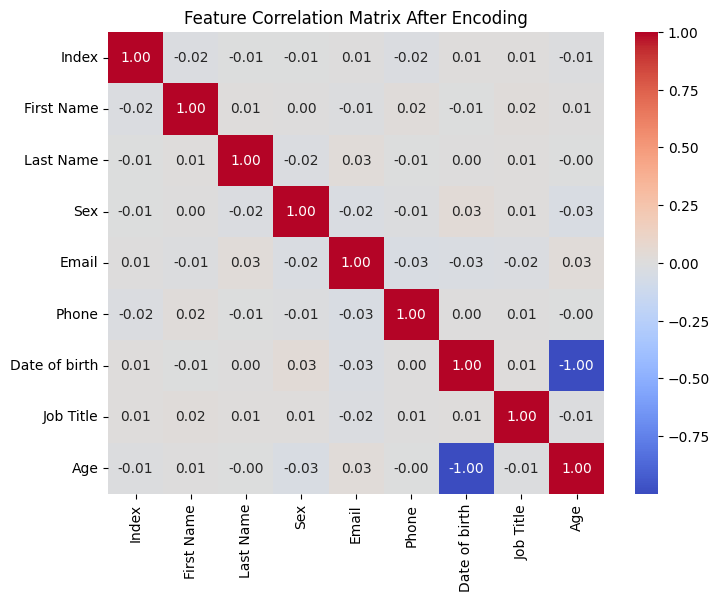

In [84]:
# Correlation matrix after encoding
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix After Encoding")
plt.show()

In [85]:
# Select features and target
X = df.drop(columns=["Job Title", "Date of birth"])
y = df["Job Title"]

In [86]:
# Encode the target variable
y_encoder = LabelEncoder()
y = y_encoder.fit_transform(y)

In [87]:
# Check class distribution
class_counts = Counter(y)
rare_classes = [cls for cls, count in class_counts.items() if count < 2]

In [88]:
# Remove rare classes
if rare_classes:
    mask = ~df["Job Title"].isin(y_encoder.inverse_transform(rare_classes))
    X = X[mask]
    y = y[mask]

In [89]:
# Split the dataset safely
stratify_option = y if min(Counter(y).values()) > 1 else None
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=stratify_option)

In [90]:
# Scaling Methods
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler()
}

scaled_data = {}
for scaler_name, scaler in scalers.items():
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    scaled_data[scaler_name] = (X_train_scaled, X_test_scaled)
    print(f"\n{scaler_name} applied:")
    print(pd.DataFrame(X_train_scaled).describe())


StandardScaler applied:
                  0             1             2             3             4  \
count  2.374000e+03  2.374000e+03  2.374000e+03  2.374000e+03  2.374000e+03   
mean   9.128708e-17  9.278359e-17  5.686736e-17  1.092452e-16 -4.639180e-17   
std    1.000211e+00  1.000211e+00  1.000211e+00  1.000211e+00  1.000211e+00   
min   -1.749348e+00 -1.729249e+00 -1.772958e+00 -1.002531e+00 -1.718142e+00   
25%   -8.680776e-01 -8.851522e-01 -8.593963e-01 -1.002531e+00 -8.653326e-01   
50%   -4.229316e-03  3.386435e-02  1.479577e-02  9.974758e-01 -3.753794e-03   
75%    8.578769e-01  8.629771e-01  8.531970e-01  9.974758e-01  8.597738e-01   
max    1.730088e+00  1.702079e+00  1.720231e+00  9.974758e-01  1.738891e+00   

                  5             6  
count  2.374000e+03  2.374000e+03  
mean  -1.945462e-17  1.032592e-16  
std    1.000211e+00  1.000211e+00  
min   -1.727931e+00 -1.535758e+00  
25%   -8.766488e-01 -8.457550e-01  
50%    1.081752e-02 -6.950167e-02  
75%    8.81

In [91]:
# Hyperparameter tuning
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10]
}

rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(scaled_data["StandardScaler"][0], y_train)  # Using StandardScaler data

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [92]:
# Best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(scaled_data["StandardScaler"][1])

In [93]:
# Evaluate
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [94]:
# Display best results
print("Best Model Parameters:", grid_search.best_params_)
print("Best Model Accuracy:", accuracy)
print("Classification Report:\n", report)

Best Model Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best Model Accuracy: 0.005128205128205128
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         2
          14       0.00      0.00  

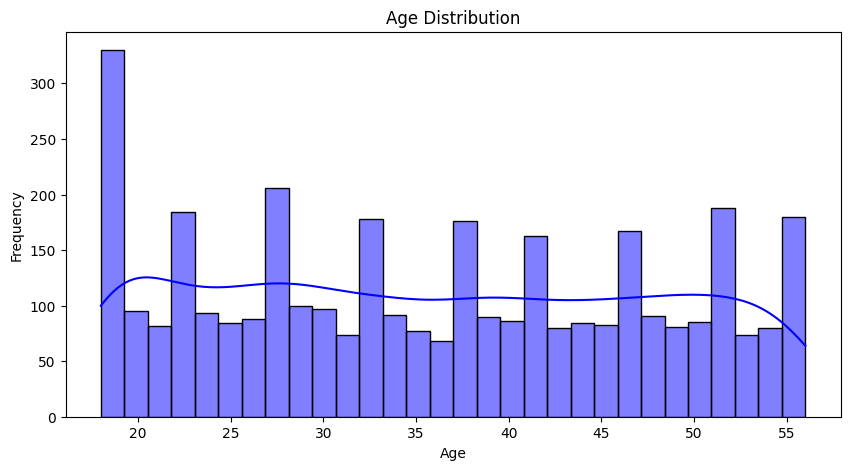

In [95]:
# Visualization
plt.figure(figsize=(10, 5))
sns.histplot(df["Age"], bins=30, kde=True, color="blue")
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

<ipython-input-96-cac0c61f11b6>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df["Job Title"], palette="coolwarm", order=df["Job Title"].value_counts().index)


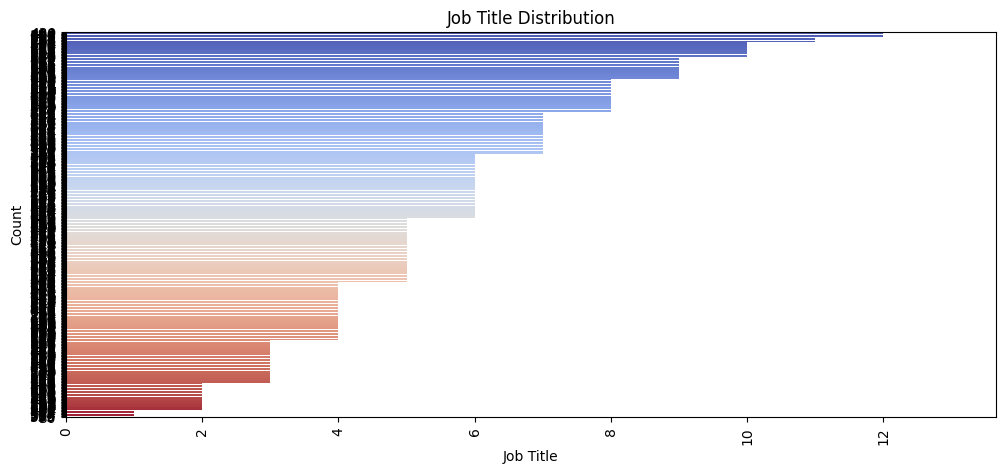

In [96]:
# Job Title distribution
plt.figure(figsize=(12, 5))
sns.countplot(y=df["Job Title"], palette="coolwarm", order=df["Job Title"].value_counts().index)
plt.xticks(rotation=90)
plt.title("Job Title Distribution")
plt.xlabel("Job Title")
plt.ylabel("Count")
plt.show()

<ipython-input-97-03bed53b8887>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Sex"], palette="viridis")


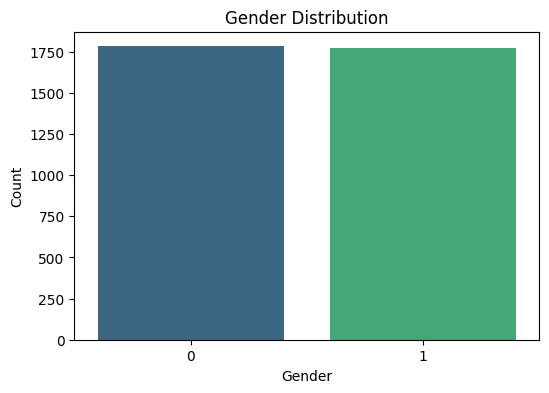

In [97]:
# Gender distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df["Sex"], palette="viridis")
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()